# AnyLoc VLAD DINOv2 Descriptors and Recall Evaluations for the Gardens Point dataset

Given a folder of images, this notebook generates global descriptors per image and stores the result in another folder. The global descriptors are created using VLAD over DINOv2 features from a particular layer and facet of transformer (default is from the paper). Assume NVIDIA GPU is available.

This notebook is adapted from https://github.com/AnyLoc/AnyLoc/blob/main/demo/anyloc_vlad_generate_colab.ipynb. We extend it by run evaluations on the Gardens Point dataset, found at https://zenodo.org/record/4590133#.ZAdKktJBxH5.
<!-- We'll use images from [FAB-MAP: Probabilistic Localization and Mapping in the Space of Appearance](https://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/) (data from [here](https://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/data.html)) as an example. This will be downloaded if it doesn't exist. -->

## Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/VNAV/

# check images exist
# imgs_dir = _ex("./data/CityCenter/Images/")
# assert os.path.isdir(cache_dir), "Cache directory not found"
# assert os.path.isdir(imgs_dir), "Invalid unzipping"
# num_imgs = len(glob.glob(f"{imgs_dir}/*.jpg"))
# print(f"Found {num_imgs} images in {imgs_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1Xg2hxidUwcEigNrOyCh3l0l05EG9Xoxe/VNAV


In [3]:
print("Verifying NVIDIA GPU is available")
!nvidia-smi -L
print("Please see that the GPU has at least 16 GB VRAM free")
!nvidia-smi

Verifying NVIDIA GPU is available
GPU 0: Tesla T4 (UUID: GPU-c278f92a-1723-4f65-8dae-06e5f8c80541)
Please see that the GPU has at least 16 GB VRAM free
Mon Dec  4 14:17:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+---------------

In [4]:
# Ensure that utilities.py module is there
import os
import requests
if os.path.isfile('utilities.py'):
    print('Found utilities.py')
else:
    print("Could not find utilities.py, downloading it")
    url = "https://raw.githubusercontent.com/AnyLoc/AnyLoc/main/demo/utilities.py"
    file_data = requests.get(url, allow_redirects=True)
    with open('utilities.py', 'wb') as handler:
        handler.write(file_data.content)
    print("Done")

Found utilities.py


In [5]:
# Install other things
print("Trying to access utility libraries")
try:
    import einops
    import fast_pytorch_kmeans
    import faiss
    import distinctipy
    # import onedrivedownloader
    print("Can access utility libraries")
except ImportError:
    print("Installing utility libraries")
    !pip install fast_pytorch_kmeans
    !pip install faiss-gpu
    !pip install einops
    !pip install distinctipy
    # !pip install onedrivedownloader

Trying to access utility libraries
Installing utility libraries
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 853.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 718.6 kB/s eta 0:00:00


## Imports

In [6]:
# Import everything
import numpy as np
import cv2 as cv
import torch
import torch.utils.data
from torch.utils.data import DataLoader

from torch import nn
from torch.nn import functional as F
from torchvision import transforms as tvf
from torchvision.transforms import functional as T
from PIL import Image
import matplotlib.pyplot as plt
import distinctipy as dipy
from tqdm.auto import tqdm
from typing import Literal, List, Tuple, Union
import os
import natsort
import shutil
from copy import deepcopy
import einops

from gardens import * # custom dataset class
 
# DINOv2 imports
from utilities import DinoV2ExtractFeatures
from utilities import VLAD

from PIL import Image
from sklearn.neighbors import NearestNeighbors
import faiss
import faiss.contrib.torch_utils

## Building Global Descriptors

Save global descriptors as numpy arrays to a directory (mirroring the directory structure of the dataset).


In [36]:
# Program parameters
# save_dir = "./cache/anyloc/descriptors/"
# save_dir = "./cache/anyloc/descriptors_urban"
save_dir = "./cache/anyloc/descriptors_indoor"

cache_dir = "./cache/anyloc"
# img_dir = "./gardens/"
device = torch.device("cuda")
# Dino_v2 properties (parameters)
desc_layer: int = 31
desc_facet: Literal["query", "key", "value", "token"] = "value"
num_c: int = 32 # 8, 16 are saved as well
# Domain for use case (deployment environment)
domain: Literal["aerial", "indoor", "urban"] = "indoor"
# Maximum image dimension
max_img_size: int = 1024

In [37]:
# Ensure inputs are fine
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    os.makedirs(save_dir+"/day_left")
    os.makedirs(save_dir+"/day_right")
    os.makedirs(save_dir+"/night_right")
    print(f"Creating directory: {save_dir}")
else:
    print("Save directory already exists, overwriting possible!")

Creating directory: ./gardens/descriptors_indoor


### DINOv2 Extractor

DINOv2 extractor and the base transformation (for each image)

In [10]:
# DINO extractor
if "extractor" in globals():
    print(f"Extractor already defined, skipping")
else:
    extractor = DinoV2ExtractFeatures("dinov2_vitg14", desc_layer,
        desc_facet, device=device)
# Base image transformations
base_tf = tvf.Compose([
    tvf.ToTensor(),
    tvf.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
])

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitg14_pretrain.pth
100%|██████████| 4.23G/4.23G [00:31<00:00, 146MB/s]


## Dataset setup

In [20]:
gardens_obj = Gardens(datasets_folder='./',
             dataset_name="gardens",
             split="train",
             use_ang_positives=False,
             dist_thresh = 10,
             ang_thresh=20,
             use_mixVPR=False,
             use_SAM=False
            )

### VLAD object

For forming global descriptors. Also loads the cluster centers (vocabulary) for VLAD.


In [13]:
def generate_descriptor(img_fname):
    with torch.no_grad():
        pil_img = Image.open(img_fname).convert('RGB')
        img_pt = base_tf(pil_img).to(device)
        if max(img_pt.shape[-2:]) > max_img_size:
            c, h, w = img_pt.shape
            # Maintain aspect ratio
            if h == max(img_pt.shape[-2:]):
                w = int(w * max_img_size / h)
                h = max_img_size
            else:
                h = int(h * max_img_size / w)
                w = max_img_size
            print(f"To {(h, w) =}")
            img_pt = T.resize(img_pt, (h, w),
                    interpolation=T.InterpolationMode.BICUBIC)
            print(f"Resized {img_fname} to {img_pt.shape = }")
        # Make image patchable (14, 14 patches)
        c, h, w = img_pt.shape
        h_new, w_new = (h // 14) * 14, (w // 14) * 14
        img_pt = tvf.CenterCrop((h_new, w_new))(img_pt)[None, ...]
        # Extract descriptor
        ret = extractor(img_pt) # [1, num_patches, desc_dim]
    return ret

In [38]:
# Either create vocabulary file based off current dataset or load from cache, then initialize VLAD object
ext_specifier = f"dinov2_vitg14/l{desc_layer}_{desc_facet}_c{num_c}"
c_centers_file = os.path.join("./vocabulary", ext_specifier,
                            domain, "c_centers.pt")
# c_centers_file = os.path.join(cache_dir, "c_centers.pt")

if os.path.isfile(c_centers_file):
    print(c_centers_file, "exists!")
    # print("Loading cached at", c_centers_file)
    # c_centers = torch.load(c_centers_file)
    # print(c_centers)
    # Fit (load) the cluster centers (this'll also load the desc_dim)
    # vlad.fit(None)

else:
    print("Building custom vocab from scratch")
    full_db_vlad = []
    vlad = VLAD(num_c, desc_dim=None, cache_dir=cache_dir)

    for img_path in tqdm(gardens_obj.db_abs_paths):
        full_db_vlad.append(generate_descriptor(img_path)[0])
    full_db_vlad = torch.stack(full_db_vlad) # format dims

    vlad.fit(einops.rearrange(full_db_vlad, "n k d -> (n k) d"))
    # n: number of images
    # k: number of patches/descriptors per image
    # d: descriptor dimension

c_centers = torch.load(c_centers_file)

assert os.path.isfile(c_centers_file), "Cluster centers not cached!"
assert c_centers.shape[0] == num_c, "Wrong number of clusters!"

./vocabulary/dinov2_vitg14/l31_value_c32/indoor/c_centers.pt exists!


In [ ]:
# For VLAD variants, we cluster all the features from the
# database images to obtain N cluster centers. This forms our
# vocabulary. The global VLAD descriptor is then calculated
# as the sum of residuals per cluster center k,

In [39]:
# set up VLAD object
vlad = VLAD(num_c, desc_dim=None,
        cache_dir=os.path.dirname(c_centers_file))
# Fit (load) the cluster centers (this'll also load the desc_dim)
vlad.fit(None)

Using cached cluster centers
Desc dim set to 1536


### Global Descriptor Generation

Main generation stage. Creating global descriptors only for the first 20 images here.

In [ ]:
def anyloc_descriptor(img_fname, save_dir, frame):
    """
    generate AnyLoc global descriptor, e.g. DINOv2 features + VLAD aggreation for an image
    (given an image path) and save it (given the save path and descriptor)

    img_fname: absolute path to image to process
    save_dir: 
    frame: either "day_right", "day_left", or "night_right" depending on which subset of dataset is being processed
    """
    # DINO features
    ret = generate_descriptor(img_fname)
    # VLAD global descriptor
    gd = vlad.generate(ret.cpu().squeeze()) # VLAD: shape [agg_dim]
    gd_np = gd.numpy()[np.newaxis, ...] # shape: [1, agg_dim]
    np.save(f"{save_dir}/{frame}/{os.path.basename(img_fname)}.npy", gd_np)

In [ ]:
# possible TODO: sift + vlad descriptor
sift = cv.SIFT_create()

# for img_fname in tqdm(img_fnames):

def sift_vlad_descriptor(img_fname, save_dir, frame):
    # SIFT features
    img = cv.cvtColor(cv.imread(img_fname), cv.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(img,None)
    # VLAD global descriptor # TODO 
    # gd = vlad.generate(ret.cpu().squeeze()) # VLAD: shape [agg_dim]
    # gd_np = gd.numpy()[np.newaxis, ...] # shape: [1, agg_dim]
    # np.save(f"{save_dir}/{frame}/{os.path.basename(img_fname)}.npy", gd_np)

In [ ]:
# build reference databases for all 3 splits of dataset
datasets = [gardens_obj.db_abs_paths, gardens_obj.q_abs_paths_night_right, gardens_obj.q_abs_paths_day_left]
for img_fnames in datasets:
    img_fnames = natsort.natsorted(img_fnames)
    frame = img_fnames[0].split("/")[-2] # this is either "day_right", "day_left", or "night_right" depending on which subset of dataset is being processed

    for img_fname in tqdm(img_fnames):
        anyloc_descriptor(img_fname, save_dir, frame) # this is modular, so could replace with another descriptor generator

## Recall evaluations

In [43]:
# This function is retrieved from https://github.com/AnyLoc/AnyLoc/blob/main/utilities.py
# %% -------------------- Recall Calculations --------------------
import faiss
import faiss.contrib.torch_utils
import typing

def get_top_k_recall(top_k: List[int], db: torch.Tensor,
        qu: torch.Tensor, gt_pos: np.ndarray, method: str="cosine",
        norm_descs: bool=True, use_gpu: bool=False,
        use_percentage: bool=True, sub_sample_db: int=1,
        sub_sample_qu: int=1) -> Tuple[np.ndarray, np.ndarray, dict]:
    """
        Given a database and query (or queries), get the top 'k'
        retrievals (closest in database for each query) as indices (in
        database), distances, and recalls.

        Parameters:
        - top_k:    List of 'k' values for recall calculation. Eg:
                    `list(range(1, 11))`.
        - db:       Database descriptors of shape [n_db, d_dim].
        - qu:       Query descriptors of shape [n_qu, d_dim]. If only
                    one query (n_qu = 1), then shape [d_dim].
        - gt_pos:   Ground truth for retrievals. Should be object type
                    with gt_pos[i] having true database items
                    (indices) for the query 'i' (in `qu`).
        - method:   Method for faiss search. In {'cosine', 'l2'}.
        - norm_descs:   If True, the descriptors are normalized in
                        function.
        - use_gpu:  True if indexing (search) should be on GPU.
        - use_percentage:   If True, the recalls are returned as a
                            percentage (of queries resolved).
        - sub_sample_db:    Sub-sample database samples from the
                            ground truth 'gt_pos'
        - sub_sample_qu:    Sub-sample query samples from the ground
                            truth 'gt_pos'

        Returns:
        - distances:    The distances of queries to retrievals. The
                        shape is [n_qu, max(top_k)]. It is the
                        distance (as specified in `method`) with the
                        database item retrieved (index in `indices`).
                        Sorted by distance.
        - indices:      Indices of the database items retrieved. The
                        shape is [n_qu, max(top_k)]. Sorted by
                        distance.
        - recalls:      A dictionary with keys as top_k integers, and
                        values are the recall (number or percentage)
                        of correct retrievals for queries.
    """
    if len(qu.shape) == 1:
        qu = qu.unsqueeze(0)
    if norm_descs:
        db = F.normalize(db)
        qu = F.normalize(qu)
    D = db.shape[1]
    if method == "cosine":
        index = faiss.IndexFlatIP(D)
    elif method == "l2":
        index = faiss.IndexFlatL2(D)
    else:
        raise NotImplementedError(f"Method: {method}")
    if use_gpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0 , index)
    # Get the max(top-k) retrieval, then traverse list
    index.add(db)
    distances, indices = index.search(qu, max(top_k))
    recalls = dict(zip(top_k, [0]*len(top_k)))
    # print(qu.shape,indices.shape)
    for i_qu, qu_retr in enumerate(indices):
        for i_rec in top_k:
            # Correct database images (for the retrieval)
            """
                i_qu * sub_sample_qu
                    Sub-sampled queries (step)
                qu_retr[:i_rec] * sub_sample_db
                    Sub-sampled database (step in retrievals)
            """
            correct_retr = gt_pos[i_qu * sub_sample_qu]
            # print(i_qu * sub_sample_qu)
            # print(correct_retr)
            # print(qu_retr[:i_rec] * sub_sample_db)
            if np.any(np.isin(qu_retr[:i_rec] * sub_sample_db,
                        correct_retr)):
                recalls[i_rec] += 1
    if use_percentage:
        for k in recalls:
            recalls[k] /= len(indices)
    return distances, indices, recalls

def check_retreival_match(qu_result, valid_positives):
  for ind in qu_result:
    if (ind in valid_positives):
      print("match found at index", ind)
      return ind, qu_result[ind] # return index and similarity
  print("returning closest match by distance")
  return list(qu_result)[0], list(qu_result.values())[0]
#   return -1, None

In [48]:
save_dir = "./cache/anyloc/descriptors_urban"
loaded_database = []
night_right_queries = []
day_left_queries = []

for img_fname in tqdm(gardens_obj.db_abs_paths):
    loaded_database.append(torch.from_numpy(np.load(f"{save_dir}/day_right/{os.path.basename(img_fname)}.npy")))

for img_fname in tqdm(gardens_obj.q_abs_paths_night_right):
    night_right_queries.append(torch.from_numpy(np.load(f"{save_dir}/night_right/{os.path.basename(img_fname)}.npy")))

for img_fname in tqdm(gardens_obj.q_abs_paths_day_left):
    day_left_queries.append(torch.from_numpy(np.load(f"{save_dir}/day_left/{os.path.basename(img_fname)}.npy")))


  0%|          | 0/200 [00:00<?, ?it/s]

In [50]:
## evaluate all of night_right and day_left queries
k = 1
top_k = list(range(1, 1+k))
print("Using k=", k)

full_db = torch.cat(loaded_database, dim=0) # reference
gt_pos = gardens_obj.soft_positives_per_query #[query_index]


day_left_matches = 0
for i in tqdm(range(len(night_right_queries))):
  qu = day_left_queries[i]
  _, indices, _  = get_top_k_recall(top_k, full_db, qu, gt_pos)
  # distances, indices = torch.Tensor.numpy(distances), torch.Tensor.numpy(indices)

  # print(np.intersect1d(indices, gt_pos[i]))
  if len(np.intersect1d(indices, gt_pos[i])) > 0:
      day_left_matches += 1
print(f"day_left_matches: {day_left_matches} of {len(day_left_queries)}, match rate: {day_left_matches/len(day_left_queries)}")


night_right_matches = 0
for i in tqdm(range(len(night_right_queries))):
  qu = night_right_queries[i]
  _, indices, _  = get_top_k_recall(top_k, full_db, qu, gt_pos)
  # distances, indices = torch.Tensor.numpy(distances), torch.Tensor.numpy(indices)

  # print(np.intersect1d(indices, gt_pos[i]))
  if len(np.intersect1d(indices, gt_pos[i])) > 0:
      night_right_matches += 1
print(f"night_right_matches: {night_right_matches} of {len(night_right_queries)}, match rate: {night_right_matches/len(night_right_queries)}")


Using k= 1


  0%|          | 0/200 [00:00<?, ?it/s]

day_left_matches 191 0.955


  0%|          | 0/200 [00:00<?, ?it/s]

night_right_matches 194 0.97


query result: {54: 0.5706924, 55: 0.5582652, 56: 0.5264828, 53: 0.51006377, 57: 0.5064705}
valid positives (ground truth): [52, 53, 54, 55, 56]
match found at index 54
night query:


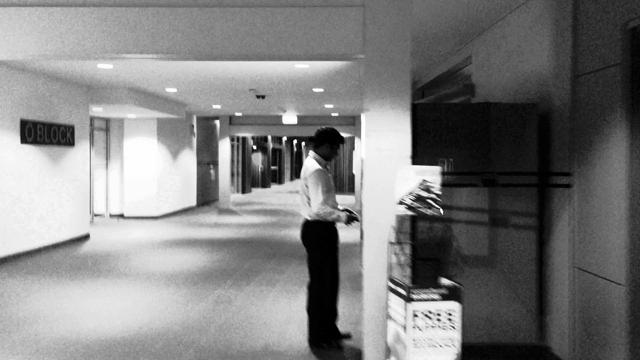

best retreival (day right), index 54


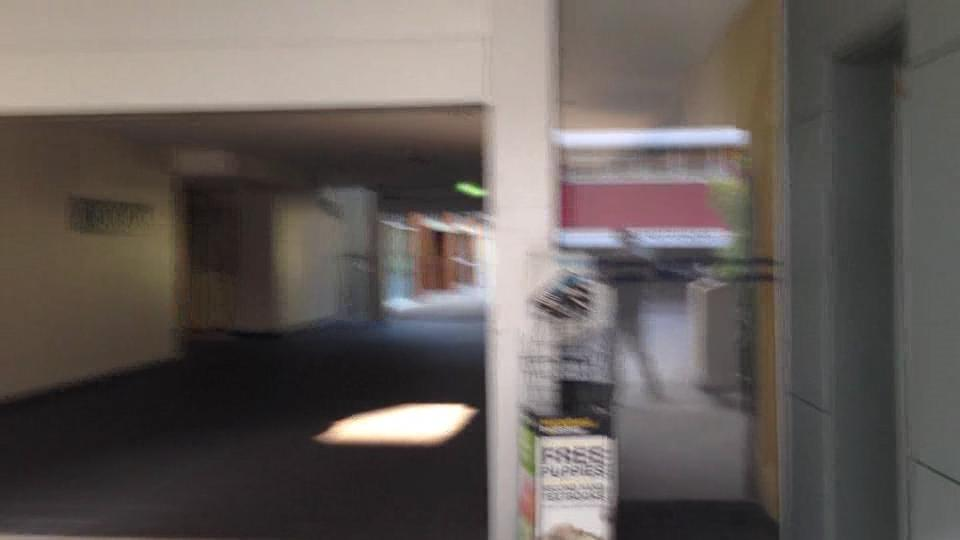

In [59]:
## inspect individual query
k = 5
top_k = list(range(1, 1+k))

full_db = torch.cat(loaded_database, dim=0) # reference

query_index = 54

qu = night_right_queries[query_index]
# qu = day_left_queries[query_index]

gt_pos = gardens_obj.soft_positives_per_query #[query_index]

# the recall output appears to not be returning meaningful results here
distances, indices, recall  = get_top_k_recall(top_k, full_db, qu, gt_pos) 
distances, indices = torch.Tensor.numpy(distances), torch.Tensor.numpy(indices)

qu_result = {indices[0][i]:distances[0][i] for i in range(k)}
print("query result:", qu_result)
# key: index of match in ref database (full_db)
# value: cossim between query qu to retreival full_db[key]
# in order from most to least similar

print("valid positives (ground truth):", gt_pos[query_index])

best_match_ind, dist = check_retreival_match(qu_result, gt_pos[query_index])

# Visualize query vs retreival
# print("day left query, index", query_index)
# display(gardens_obj.show_day_left_item(query_index))

print("night query, index", query_index)
display(gardens_obj.show_night_right_item(query_index))

print("best retreival (day right), index", best_match_ind)
display(gardens_obj.show_day_right_item(best_match_ind))